In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import onnx
import os

# Preprocessing: load the ONNX model
model_path = './onnx2graphml/resources/resnet50.onnx'
onnx_model = onnx.load(model_path)

print('The model is:\n{}'.format(onnx_model))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
type(onnx_model)

onnx.onnx_ONNX_REL_1_4_ml_pb2.ModelProto

In [4]:
import networkx as nx
from typing import Text, Sequence, Any, Optional, Dict, Union, TypeVar, Callable, Tuple, List, cast

In [5]:
def _sanitize_str(s):  # type: (Union[Text, bytes]) -> Text
    if isinstance(s, text_type):
        sanitized = s
    elif isinstance(s, binary_type):
        sanitized = s.decode('utf-8', errors='ignore')
    else:
        sanitized = str(s)
    if len(sanitized) < 64:
        return sanitized
    else:
        return sanitized[:64] + '...<+len=%d>' % (len(sanitized) - 64)

In [6]:
def networkxable_attribute(attr, subgraphs=False):  # type: (AttributeProto, bool) -> Union[Text, Tuple[Text, List[GraphProto]]]
    key = attr.name
    value = []

    def str_float(f):  # type: (float) -> Text
        # NB: Different Python versions print different numbers of trailing
        # decimals, specifying this explicitly keeps it consistent for all
        # versions
        return '{:.15g}'.format(f)

    def str_int(i):  # type: (int) -> Text
        # NB: In Python 2, longs will repr() as '2L', which is ugly and
        # unnecessary.  Explicitly format it to keep it consistent.
        return '{:d}'.format(i)

    def str_str(s):  # type: (Text) -> Text
        return repr(s)

    _T = TypeVar('_T')  # noqa

    def str_list(str_elem, xs):  # type: (Callable[[_T], Text], Sequence[_T]) -> Text
        return '[' + ', '.join(map(str_elem, xs)) + ']'

    # for now, this logic should continue to work as long as we are running on a proto3
    # implementation. If/when we switch to proto3, we will need to use attr.type

    # To support printing subgraphs, if we find a graph attribute, print out
    # its name here and pass the graph itself up to the caller for later
    # printing.

    if attr.HasField("f"):
        value.append(str_float(attr.f))
    elif attr.HasField("i"):
        value.append(str_int(attr.i))
    elif attr.HasField("s"):
        # TODO: Bit nervous about Python 2 / Python 3 determinism implications
        value.append(repr(_sanitize_str(attr.s)))
    elif attr.HasField("t"):
        if len(attr.t.dims) > 0:
            value.append("<Tensor>")
        else:
            # special case to print scalars
            field = STORAGE_TENSOR_TYPE_TO_FIELD[attr.t.data_type]
            value.append('<Scalar Tensor {}>'.format(str(getattr(attr.t, field))))
#     elif attr.HasField("g"):
#         value.append("<graph {}>".format(attr.g.name))
#         graphs.append(attr.g)
    elif attr.floats:
        value.append(str_list(str_float, attr.floats))
    elif attr.ints:
        value.append(str_list(str_int, attr.ints))
    elif attr.strings:
        # TODO: Bit nervous about Python 2 / Python 3 determinism implications
        value.append(str(list(map(_sanitize_str, attr.strings))))
    elif attr.tensors:
        value.append("[<Tensor>, ...]")
        
#     elif attr.graphs:
#         content.append('[')
#         for i, g in enumerate(attr.graphs):
#             comma = ',' if i != len(attr.graphs) - 1 else ''
#             content.append('<graph {}>{}'.format(g.name, comma))
#         content.append(']')
#         graphs.extend(attr.graphs)
    else:
        value.append("<Unknown>")
#     if subgraphs:
#         return ' '.join(value), graphs
#     else:
    return key, ' '.join(value)

In [64]:
def _get_out_name(node):
    if len(node.output) > 0:
        outputs = [ str(out_name) for out_name in node.output]
    else:
        outputs = [node.output]
        
    return outputs[0]

def _get_node_name(node):
    return node.name if len(node.name) > 0 else _get_out_name(node)

In [65]:
def networkxable_node(node, prefix='', subgraphs=False):  # type: (NodeProto, Text, bool) -> Union[Text, Tuple[Text, List[GraphProto]]]
    '''
    Adapted from onnx.helper.printable_graph()
    https://github.com/onnx/onnx/blob/dd599b05f424eb161a31f3e059566a33310dbe5e/onnx/helper.py#L455
    '''
#     content = []
#     if len(node.output):
#         content.append(
#             ', '.join(['%{}'.format(name) for name in node.output]))
#         content.append('=')
#     # To deal with nested graphs
#     graphs = []  # type: List[GraphProto]
    
    attrs = {}
    for attr in node.attribute:
#         if subgraphs:
#             printed_attr, gs = printable_attribute(attr, subgraphs)
#             assert isinstance(gs, list)
#             graphs.extend(gs)
#             printed_attrs.append(printed_attr)
#         else:
        k, v = networkxable_attribute(attr)
        assert isinstance(v, Text)
        attrs[k] = v
        
    attrs['op_type'] = node.op_type
    
    node_name = _get_node_name(node)
            
#     printed_attributes = ', '.join(sorted(printed_attrs))
#     printed_inputs = ', '.join(['%{}'.format(name) for name in node.input])
    
#     if node.attribute:
#         content.append("{}[{}]({})".format(node.op_type, printed_attributes, printed_inputs))
#     else:
#         content.append("{}({})".format(node.op_type, printed_inputs))
    
#     if subgraphs:
#         return prefix + ' '.join(content), graphs
#     else:
    return node_name, attrs


In [80]:
def networkxable_graph(graph, prefix=''):  # type: (GraphProto, Text) -> Text
    '''
    Adapted from onnx.helper.printable_graph()
    https://github.com/onnx/onnx/blob/dd599b05f424eb161a31f3e059566a33310dbe5e/onnx/helper.py#L486
    '''
    DG = nx.DiGraph()
    initialized = {t.name for t in graph.initializer}
    
    if len(graph.input):
        in_strs = []
        init_strs = []
        for inp in graph.input:
            if inp.name not in initialized:
                DG.add_node(inp.name)
#             else:
#                 DG.add_node(inp.name)
#         if in_strs:
#             content.append(prefix + ' '.join(header))
#             header = []
#             for line in in_strs:
#                 content.append(prefix + '  ' + line)
#         header.append(")")

#         if init_strs:
#             header.append("initializers (")
#             content.append(prefix + ' '.join(header))
#             header = []
#             for line in init_strs:
#                 content.append(prefix + '  ' + line)
#             header.append(")")

#     header.append('{')
#     content.append(prefix + ' '.join(header))
#     graphs = []  # type: List[GraphProto]
#     # body
    
    # ADD NODES
    for node in graph.node:
        nname, nattrs = networkxable_node(node)
        DG.add_node(nname, **nattrs)
        
    # ADD EDGES
    for node in graph.node:
        for innode in node.input:
            if innode not in initialized:
                DG.add_edge(innode, _get_node_name(node))
        
    
#         content.append(pn)
#         graphs.extend(gs)
#     # tail
#     tail = ['return']
#     if len(graph.output):
#         tail.append(
#             ', '.join(['%{}'.format(out.name) for out in graph.output]))
#     content.append(indent + ' '.join(tail))
#     # closing bracket
#     content.append(prefix + '}')
#     for g in graphs:
#         DG.append('\n' + printable_graph(g))
    return DG

In [81]:
g = networkxable_graph(onnx_model.graph)
g

In [82]:
import matplotlib as plt
%matplotlib inline

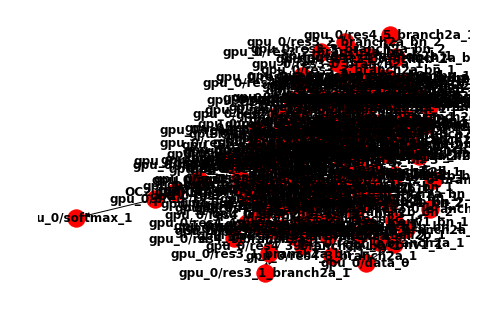

In [78]:
nx.draw(g, with_labels=True, font_weight='bold')

In [83]:
nx.write_graphml(g, "resnet50.graphml")

In [1]:
from onnx2graphml import convert

In [2]:
convert.convert('lenet.onnx','lenet2.graphml')

In [71]:
g2 = nx.read_graphml('resnet50.graphml')

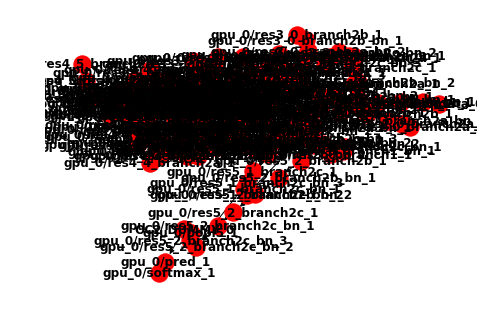

In [72]:
nx.draw(g2, with_labels=True, font_weight='bold')

In [6]:
import matplotlib as plt
%matplotlib inline

In [59]:
print("Model fields")
for field in onnx_model.DESCRIPTOR.fields_by_name:
    print ("\t" + field)
    
print("\nGraph fields")
for field in onnx_model.graph.DESCRIPTOR.fields_by_name:
    print ("\t" + field)

Model fields
	ir_version
	opset_import
	producer_name
	producer_version
	domain
	model_version
	doc_string
	graph
	metadata_props

Graph fields
	node
	name
	initializer
	doc_string
	input
	output
	value_info
	quantization_annotation


In [73]:
print(onnx_model.graph.node)

[input: "gpu_0/data_0"
input: "gpu_0/conv1_w_0"
output: "gpu_0/conv1_1"
name: ""
op_type: "Conv"
attribute {
  name: "pads"
  ints: 3
  ints: 3
  ints: 3
  ints: 3
  type: INTS
}
attribute {
  name: "kernel_shape"
  ints: 7
  ints: 7
  type: INTS
}
attribute {
  name: "strides"
  ints: 2
  ints: 2
  type: INTS
}
, input: "gpu_0/conv1_1"
input: "gpu_0/res_conv1_bn_s_0"
input: "gpu_0/res_conv1_bn_b_0"
input: "gpu_0/res_conv1_bn_rm_0"
input: "gpu_0/res_conv1_bn_riv_0"
output: "gpu_0/res_conv1_bn_1"
name: ""
op_type: "BatchNormalization"
attribute {
  name: "epsilon"
  f: 1.00000006569e-05
  type: FLOAT
}
, input: "gpu_0/res_conv1_bn_1"
output: "gpu_0/res_conv1_bn_2"
name: ""
op_type: "Relu"
, input: "gpu_0/res_conv1_bn_2"
output: "gpu_0/pool1_1"
name: ""
op_type: "MaxPool"
attribute {
  name: "pads"
  ints: 1
  ints: 1
  ints: 1
  ints: 1
  type: INTS
}
attribute {
  name: "kernel_shape"
  ints: 3
  ints: 3
  type: INTS
}
attribute {
  name: "strides"
  ints: 2
  ints: 2
  type: INTS
}
, 

In [74]:
g.nodes

NodeView(('gpu_0/res4_1_branch2c_bn_1', 'gpu_0/res3_2_branch2b_1', 'gpu_0/res3_3_branch2c_bn_1', 'gpu_0/res4_2_branch2b_1', 'gpu_0/res4_0_branch2c_bn_3', 'gpu_0/res4_0_branch2c_bn_2', 'gpu_0/res4_0_branch2c_bn_1', 'gpu_0/res3_0_branch2a_bn_2', 'gpu_0/res4_5_branch2c_bn_3', 'gpu_0/res3_0_branch2a_bn_1', 'gpu_0/res3_3_branch2b_bn_1', 'gpu_0/res3_3_branch2b_bn_2', 'gpu_0/res4_3_branch2c_bn_3', 'gpu_0/res2_1_branch2b_1', 'gpu_0/res4_0_branch2a_bn_1', 'gpu_0/res4_2_branch2c_bn_3', 'gpu_0/res4_0_branch2a_bn_2', 'gpu_0/res4_4_branch2a_bn_1', 'gpu_0/res4_4_branch2a_bn_2', 'gpu_0/res4_5_branch2b_1', 'gpu_0/res4_1_branch2c_1', 'gpu_0/res3_3_branch2c_bn_3', 'gpu_0/res2_1_branch2c_bn_1', 'gpu_0/res2_1_branch2c_bn_2', 'gpu_0/res2_1_branch2c_bn_3', 'gpu_0/res4_1_branch2a_1', 'gpu_0/res2_0_branch2b_bn_2', 'gpu_0/res4_3_branch2c_bn_1', 'gpu_0/res4_3_branch2c_bn_2', 'gpu_0/res2_0_branch2b_bn_1', 'gpu_0/res4_0_branch2b_1', 'gpu_0/res4_5_branch2b_bn_1', 'gpu_0/res4_5_branch2b_bn_2', 'gpu_0/res2_0_branch2